Starting from [45:50](https://www.youtube.com/watch?v=l8pRSuU81PU&t=2750s)

# Code from the previous notebook

In [1]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # maximum sequence length
    vocab_size: int = 50257 # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding size

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                            .view(1, 1, config.block_size, config.block_size))
    
    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size() 
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        # Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # apply the mask
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # apply the softmax
        att = F.softmax(att, dim=-1)
        # apply the attention
        y = att @ v
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y
        

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate = "tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
    

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # maximum sequence length
    vocab_size: int = 50257 # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding size

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        return logits

# Prepare training dataset

In [3]:
with open("input.txt", "r") as f:
    text = f.read()
data = text[:1000]
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:25])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13, 198]


In [4]:
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [5]:
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)
x, y = x.to("mps"), y.to("mps")

model = GPT(GPTConfig())
model.to("mps")
logits = model(x)
print(f"Shape of logits: {logits.shape}")

Shape of logits: torch.Size([4, 32, 50257])


# Modify the forward function to include the loss

In [6]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets = None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # (B * T, vocab_size)
        return logits, loss

In [7]:
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)
x, y = x.to("mps"), y.to("mps")

model = GPT(GPTConfig())
model.to("mps")
logits, loss = model(x, y)
print(f"Shape of logits: {logits.shape}")
print(f"loss is {loss}")

Shape of logits: torch.Size([4, 32, 50257])
loss is 11.008321762084961


In [8]:
# The probability of each token should be roughly equal
probability = 1 / logits.shape[-1]
print(f"probability of each token is {probability}")
# Expected loss at initialization should be -log(1 / vocab_size)
nll = -torch.log(torch.tensor(probability))
print(f"Negative log likelihood is {nll}")

probability of each token is 1.9897725689953638e-05
Negative log likelihood is 10.824905395507812


# Training Loop

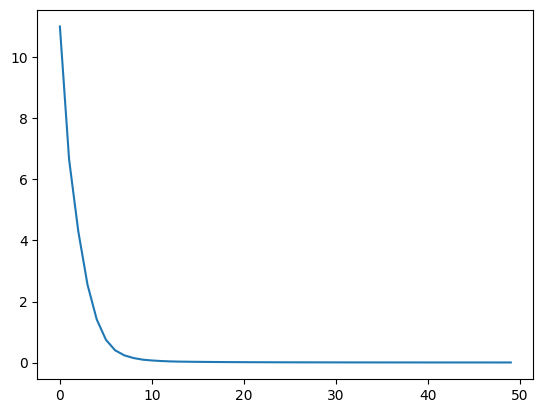

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

# Prepare Dataloader

In [10]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        
        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        self.current_position = 0
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position + (B * T) + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        self.current_position += B * T
        # reset if we reach the end
        if self.current_position + (B * T) + 1 > len(self.tokens):
            self.current_position = 0
        return x, y

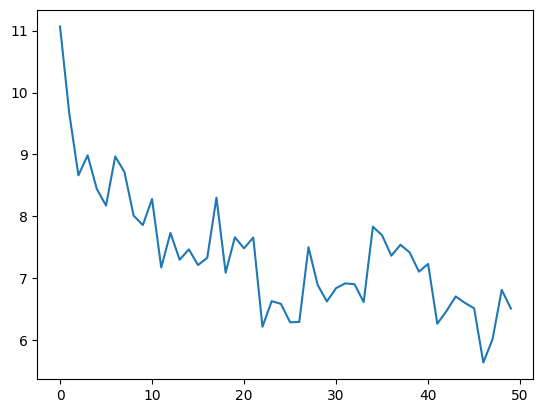

In [11]:
model = GPT(GPTConfig())
model.to("mps")
train_loader = DataLoaderLite(4, 32)
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("mps"), y.to("mps")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

# Fixing a bug: Weight Sharing

## Check Huggingface implementation

In [12]:
from transformers import GPT2LMHeadModel
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

In [13]:
print(sd_hf["lm_head.weight"].shape) # At the head
print (sd_hf["transformer.wte.weight"].shape) # At the bottom

# They are the same
print((sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()) # True

# Print the data pointers (They are stored in the same memory location)
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

# Print number of trainable parameters
num_params = sum(p.numel() for p in model_hf.parameters() if p.requires_grad)
print(f"Number of trainable parameters in the model: {num_params}")

torch.Size([50257, 768])
torch.Size([50257, 768])
tensor(True)
18832306131
18832306131
Number of trainable parameters in the model: 124439808


In [14]:
del model_hf, sd_hf

## Apply weight Sharing to our model

In [15]:
# current model (different data pointers)
print(f"{model.state_dict()["transformer.wte.weight"].data_ptr()}")
print(f"{model.state_dict()["lm_head.weight"].data_ptr()}")
# print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

13872034128
13876295264
163037184


In [16]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

    def forward(self, idx, targets = None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # (B * T, vocab_size)
        return logits, loss

In [17]:
model = GPT(GPTConfig())
model.to("mps")
# current model (same data pointers)
print(f"{model.state_dict()["transformer.wte.weight"].data_ptr()}")
print(f"{model.state_dict()["lm_head.weight"].data_ptr()}")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

15161625952
15161625952
124439808


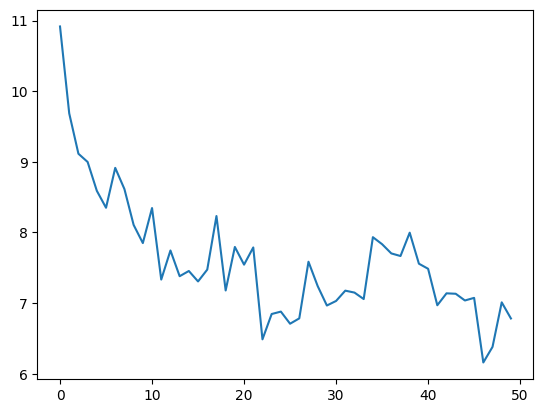

In [18]:
train_loader = DataLoaderLite(4, 32)
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("mps"), y.to("mps")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)

# Initialization

In [19]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)

    def forward(self, idx, targets = None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # (B * T, vocab_size)
        return logits, loss

## Residual Init

In [20]:
x = torch.zeros(768)
n = 100 # e.g., 100 layers
for i in range(n):
    x += torch.randn(768) # Additive noise
print(x.std())

tensor(9.9980)


In [21]:
x = torch.zeros(768)
n = 100 # e.g., 100 layers
for i in range(n):
    x += torch.randn(768) / torch.sqrt(torch.tensor(n)) # Additive noise divided by sqrt(n)
print(x.std()) # it should be 1

tensor(0.9957)


In [22]:
# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                            .view(1, 1, config.block_size, config.block_size))
    
    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size() 
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, n_head, T, hs)
        # Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # apply the mask
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # apply the softmax
        att = F.softmax(att, dim=-1)
        # apply the attention
        y = att @ v
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y

In [23]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate = "tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [24]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [25]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict({
            # token embedding
            "wte": nn.Embedding(config.vocab_size, config.n_embd),
            # positional embedding
            "wpe": nn.Embedding(config.block_size, config.n_embd),
            # transformer layers
            "h" : nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            # final layer norm (Before the Linear layer)
            "ln_f" : nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            # 1 / sqrt(2 * number of residual layers) note that each layer has two residual connections
            std *= (2 * self.config.n_layer) ** -0.5 
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = std)

    def forward(self, idx, targets = None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype = torch.long, device = idx.device) # Shape is (T)
        pos_emb = self.transformer.wpe(pos) # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx) # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x) # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # (B * T, vocab_size)
        return logits, loss

In [28]:
model = GPT(GPTConfig())
model.to("mps")

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

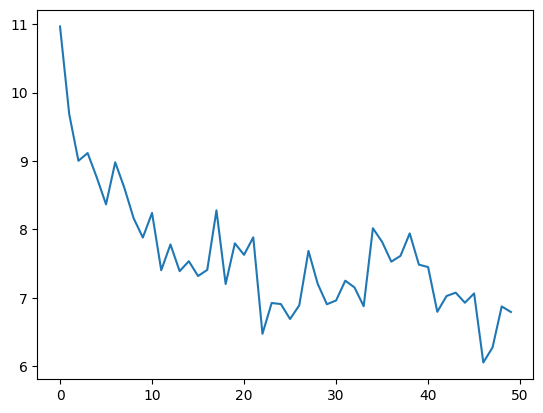

In [29]:
train_loader = DataLoaderLite(4, 32)
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("mps"), y.to("mps")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)